# Transfer Learning Example
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2022-11-03 00:32:52.403917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 00:32:52.504507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 00:32:52.504523: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-03 00:32:52.527906: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 00:32:53.128798: W tensorflow/stream_executor/platform/de

### Download the Data

In [2]:
data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=data_url, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

### Create Training and Validation Datasets from the Downloaded Data

In [4]:
BATCH_SIZE=32
IMG_SIZE = (160, 160)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode="categorical")

Found 2000 files belonging to 2 classes.


2022-11-03 00:32:55.313179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-03 00:32:55.313201: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 00:32:55.313217: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (78359bdf0297): /proc/driver/nvidia/version does not exist
2022-11-03 00:32:55.313416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode="categorical")

Found 1000 files belonging to 2 classes.


### Show the First Few Images With Class Names

In [7]:
class_names = train_dataset.class_names

In [10]:
class_names

['cats', 'dogs']

In [ ]:
num_classes = len(class_names)

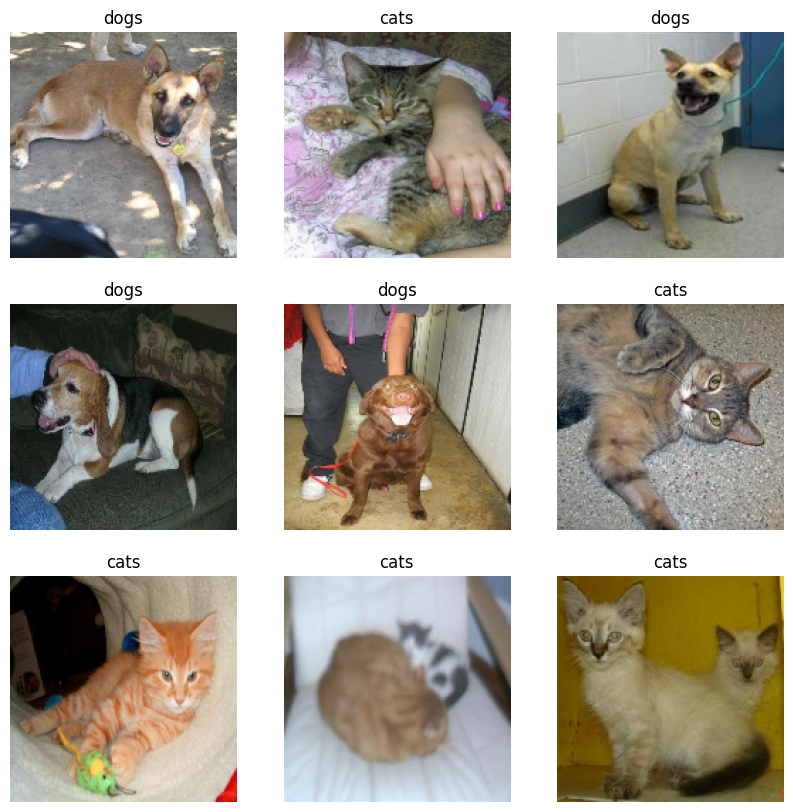

In [12]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

### Create a Test Set from a Subset of the Validation Set

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print(f"Number of Validation Batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of Test Batches: {tf.data.experimental.cardinality(test_dataset)}")

Number of Validation Batches: 26
Number of Test Batches: 6


### Configure Prefetching to Increase Performance
Prefetching will allow tensorflow to begin pre-processing the next batch of images while training on the current set.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Augment the Dataset (Create Modified Copies of Existing Dataset to Artifically Increase Size of Dataset)

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)])

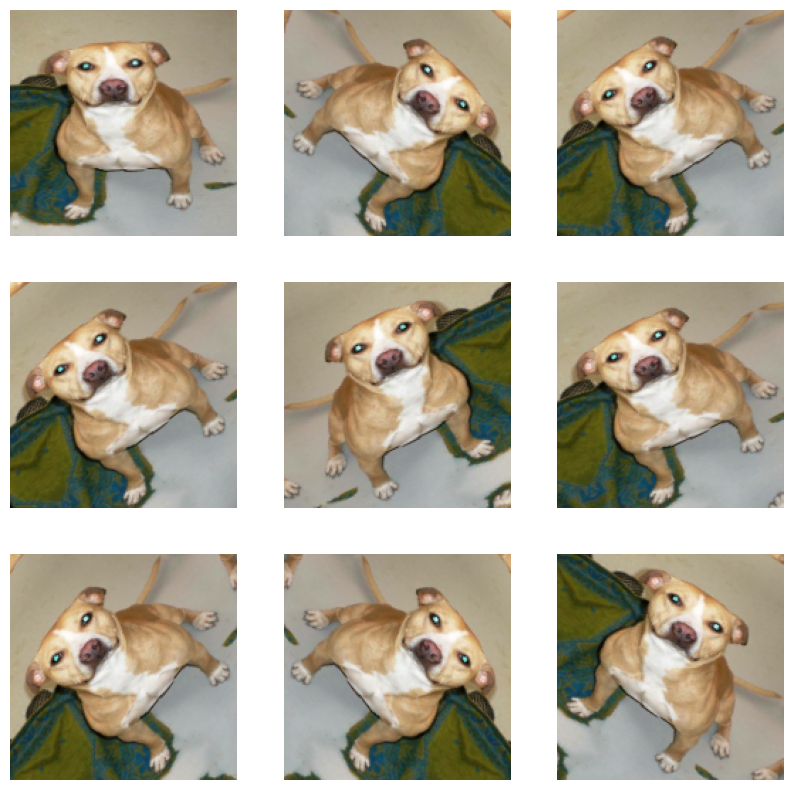

In [17]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Preprocess the Input For MobileNetV2

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
##Alternative preprocessing option is to use tf.keras.layers.Rescaling 
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create Base Model (excluding the Top Layer)

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Freeze the Convolutional Base (prevents weights in base_model layers from being updated during training)

In [22]:
base_model.trainable = False

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a Classification Head

The global average layer will convert the features into a single vector per image

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


A Dense layer will create an array of probabilities that a given image belongs to each class. (e.g. if we have 3 classes, each image will get a prediction array with three values)

**IMPORTANT NOTE: The number of nodes in the Dense layer below MUST equal the number of classes you are training/predicting. (e.g. if we have 3 classes, the Dense layer should have 3 nodes)

In [25]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


### Chain All of the Steps Above Together to Build the Model

In [26]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)

#When you unfreeze a model that contains BatchNormalization layers in order to do 
# fine-tuning, you should keep the BatchNormalization layers in inference mode by 
# passing training = False when calling the base model. Otherwise, the updates 
# applied to the non-trainable weights will destroy what the model has learned.
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the Model

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                                                 loss = "categorical_crossentropy",
                                                 metrics=["accuracy"])

In [28]:
model.summary() # note the number of trainable vs non-trainable params

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
print("Trainable Variables:", len(model.trainable_variables))
model.trainable_variables

Trainable Variables: 2


[<tf.Variable 'dense/kernel:0' shape=(1280, 2) dtype=float32, numpy=
 array([[ 0.00237395,  0.03859153],
        [ 0.03579953, -0.05918958],
        [-0.00308856,  0.05735301],
        ...,
        [-0.06587045, -0.00081524],
        [ 0.02669242,  0.06690475],
        [-0.02036923, -0.00402755]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

### Train the Model

In [30]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 7s 217ms/step - loss: 1.0696 - accuracy: 0.4455


In [31]:
print(f"Initial Loss: {loss0}")
print(f"Initial Accuracy: {accuracy0}")

Initial Loss: 1.069582462310791
Initial Accuracy: 0.4455445408821106


In [32]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 24s 340ms/step - loss: 0.8570 - accuracy: 0.5585 - val_loss: 0.5007 - val_accuracy: 0.7550
Epoch 2/10
63/63 [==============================] - 22s 349ms/step - loss: 0.5252 - accuracy: 0.7430 - val_loss: 0.3134 - val_accuracy: 0.8886
Epoch 3/10
63/63 [==============================] - 21s 331ms/step - loss: 0.4054 - accuracy: 0.8195 - val_loss: 0.2277 - val_accuracy: 0.9307
Epoch 4/10
63/63 [==============================] - 23s 358ms/step - loss: 0.3157 - accuracy: 0.8670 - val_loss: 0.1857 - val_accuracy: 0.9455
Epoch 5/10
63/63 [==============================] - 21s 331ms/step - loss: 0.2748 - accuracy: 0.8900 - val_loss: 0.1544 - val_accuracy: 0.9592
Epoch 6/10
63/63 [==============================] - 21s 340ms/step - loss: 0.2395 - accuracy: 0.9000 - val_loss: 0.1373 - val_accuracy: 0.9604
Epoch 7/10
63/63 [==============================] - 22s 343ms/step - loss: 0.2225 - accuracy: 0.9105 - val_loss: 0.1177 - val_accuracy: 0.9691

### Plot the Learning Curves

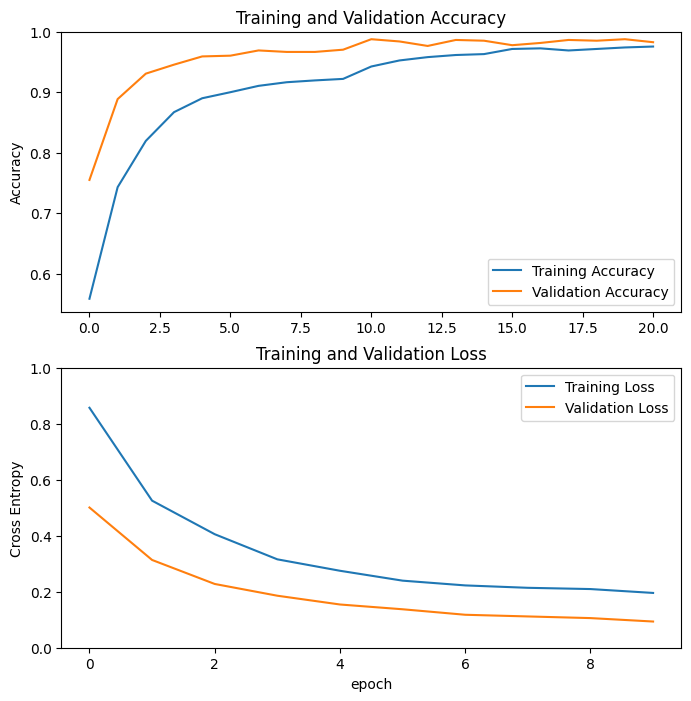

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tune the Model by Unfreezing Just the Top Layers of the Base Model

In [67]:
base_model.trainable = True

In [56]:
print(f"Number of layers in base model: {len(base_model.layers)}")

Number of layers in base model: 154


In [57]:
fine_tune_at = 100

#Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[0:fine_tune_at]:
    layer.trainable = False

### Recompile The Model
Use a lower learning rate since the model being trained is much larger and could overfit quickly

In [58]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics = ["accuracy"])

In [59]:
model.summary() # note the number of trainable params now

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [60]:
len(model.trainable_variables)

56

### Continue Training the Model

In [61]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 36s 494ms/step - loss: 0.1537 - accuracy: 0.9425 - val_loss: 0.0479 - val_accuracy: 0.9876
Epoch 11/20
63/63 [==============================] - 29s 461ms/step - loss: 0.1272 - accuracy: 0.9525 - val_loss: 0.0414 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 30s 471ms/step - loss: 0.1088 - accuracy: 0.9580 - val_loss: 0.0573 - val_accuracy: 0.9765
Epoch 13/20
63/63 [==============================] - 29s 457ms/step - loss: 0.0993 - accuracy: 0.9615 - val_loss: 0.0413 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 31s 489ms/step - loss: 0.0910 - accuracy: 0.9630 - val_loss: 0.0400 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 32s 503ms/step - loss: 0.0773 - accuracy: 0.9715 - val_loss: 0.0429 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 29s 466ms/step - loss: 0.0779 - accuracy: 0.9725 - val_loss: 0.0443 - val_accuracy:

### Plot the New Learning Curves

In [64]:
history_fine.history

{'loss': [0.1536688506603241,
  0.12718433141708374,
  0.10876864939928055,
  0.09927752614021301,
  0.0909605622291565,
  0.07733457535505295,
  0.07793247699737549,
  0.07864508032798767,
  0.062180012464523315,
  0.06458605080842972,
  0.06160249933600426],
 'accuracy': [0.9424999952316284,
  0.9524999856948853,
  0.9580000042915344,
  0.9614999890327454,
  0.9629999995231628,
  0.9714999794960022,
  0.9725000262260437,
  0.968999981880188,
  0.9714999794960022,
  0.9739999771118164,
  0.9754999876022339],
 'val_loss': [0.047940392047166824,
  0.0414341576397419,
  0.05733159929513931,
  0.04125566408038139,
  0.04001148045063019,
  0.042855244129896164,
  0.04433514177799225,
  0.03542187064886093,
  0.03510269522666931,
  0.04024307802319527,
  0.03976822271943092],
 'val_accuracy': [0.9876237511634827,
  0.9839109182357788,
  0.9764851331710815,
  0.9863861203193665,
  0.9851484894752502,
  0.9777227640151978,
  0.9814356565475464,
  0.9863861203193665,
  0.9851484894752502,
  0.

In [70]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

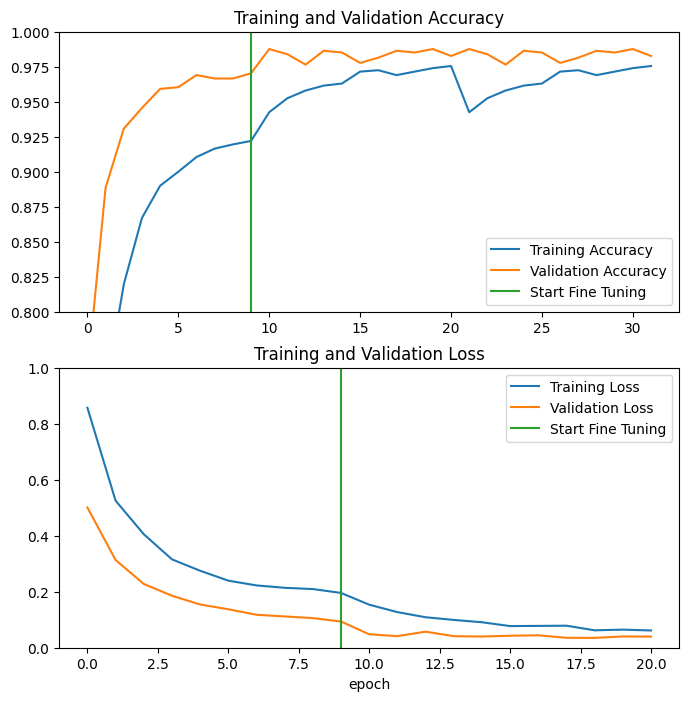

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Make Predictions on the Test Set

In [72]:
loss, accuracy = model.evaluate(test_dataset)

6/6 [==============================] - 2s 234ms/step - loss: 0.0343 - accuracy: 0.9792


In [73]:
print(loss, accuracy)

0.03427312150597572 0.9791666865348816


In [74]:
# Retrieve images from test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = [np.argmax(pred) for pred in predictions]

Predictions:
 [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Labels:
 [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]


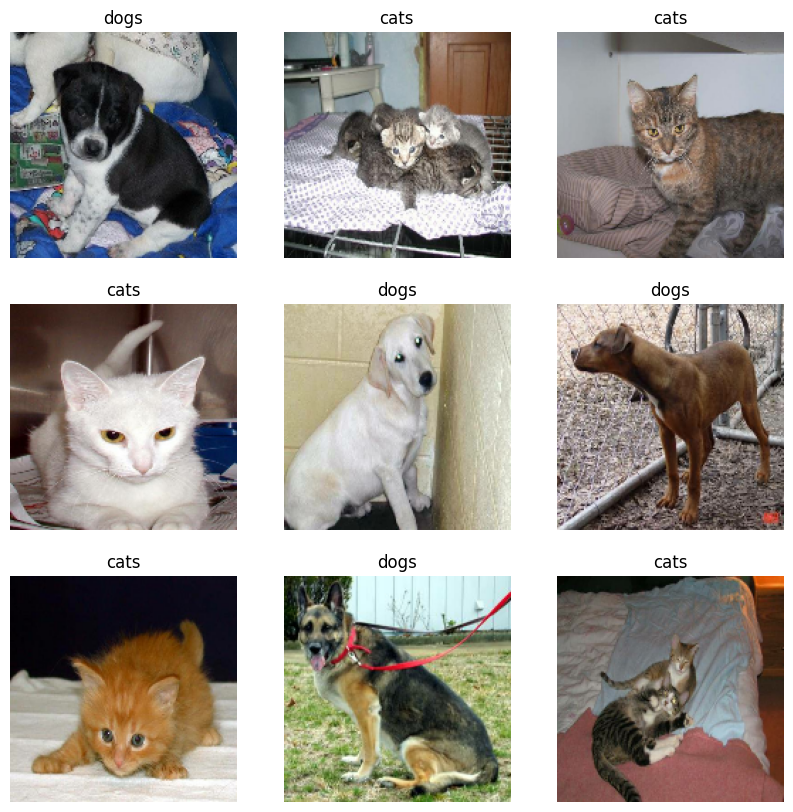

In [75]:
print(f"Predictions:\n {predictions}")
print(f"Labels:\n {[np.argmax(label) for label in label_batch]}")

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [ ]:
def predict_on_file(path:str) -> None:
    
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)

    # img.show() #Uncomment this line to show the image that is being classified

    img_array = np.array(img)
    img_batch = np.expand_dims(img_array, 0) # need to add a dimension at 0 index (this gives us a "batch" with one image, which is the required input shape)

    prediction_confidence_values = model.predict_on_batch(img_batch)[0]
    predicted_class_num = np.argmax(prediction_confidence_values)
    predicted_class_name = class_names[predicted_class_num]

    print(f"Confidence Levels: {dict(zip(class_names,prediction_confidence_values))}")

    print(f"Predicted Class: {predicted_class_name}")

In [ ]:
predict_on_file("/path/to/your/file")

### Next
See https://www.tensorflow.org/guide/keras/transfer_learning for more info on transfer learning